In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import heapq
from mpl_toolkits.mplot3d import Axes3D
import csv

# Adaptive Line-of-Sight (ALoS) Optimization of LoRa signals for Drone Communication

In [ ]:
class UAVEnvironment:
    def __init__(self, depth_matrix, target=(8, 8)):
        self.depth_matrix = depth_matrix
        self.target = target
        self.state = (0, 0, depth_matrix[0, 0])  # Initial state (x, y, z)
        self.done = False

    def calculate_signal_strength(self, state):
        x1, y1, z1 = state
        x2, y2 = self.target
        signal_strength = 1.0  # Default signal strength
        distance = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

        # Calculate line equation coefficients
        m = (x2 - x1) / distance if distance != 0 else np.inf  # Avoid division by zero
        n = (y2 - y1) / distance if distance != 0 else 0

        # Count obstacles intersecting the line
        obstacles_count = 0
        for i in range(int(min(x1, x2)), int(max(x1, x2)) + 1):
            if m != 0:
                j = int((i - x1) * n / m + y1)  # Calculate y-coordinate on the line
            else:
                j = int(y1)  # Line is vertical, y-coordinate is constant
            if 0 <= j < self.depth_matrix.shape[0] and self.depth_matrix[j, i] > z1:
                obstacles_count += 1

        # Adjust signal strength based on obstacle count
        signal_strength -= obstacles_count * 0.1

        return signal_strength

    def reset(self):
        self.state = (0, 0, self.depth_matrix[0, 0])  # Reset to initial state
        self.done = False
        return self.state

    def step(self, action):
        x, y, z = self.state

        if action == 0:  # Move along x-axis
            next_x = max(0, min(x + 1, self.depth_matrix.shape[1] - 1))
            next_state = (next_x, y, z)
        elif action == 1:  # Move along y-axis
            next_y = max(0, min(y + 1, self.depth_matrix.shape[0] - 1))
            next_state = (x, next_y, z)
        elif action == 2:  # Move along z-axis
            next_z = min(max(z + 1, 0), self.depth_matrix[y, x])  # Ensure z does not exceed the depth matrix value at the current position
            next_state = (x, y, next_z)
        else:
            raise ValueError("Invalid action.")

        # Check if the UAV hits an obstacle or reaches the target
        if self.depth_matrix[next_state[1], next_state[0]] != 0 or next_state[:2] == self.target:
            self.done = True

        # Calculate reward based on reaching the target or hitting an obstacle
        if next_state[:2] == self.target:
            reward = 100
        elif self.depth_matrix[next_state[1], next_state[0]] != 0:
            reward = -10
        else:
            reward = -1

        self.state = next_state
        return next_state, reward, self.done



class DuelingQLearningAgent:
    def __init__(self, env, learning_rate=0.1, discount_factor=0.99, epsilon_initial=1.0, epsilon_min=0.01, epsilon_decay=0.995, alpha=0.1):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon_initial = epsilon_initial
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.alpha = alpha
        # Initialize Q-values for each state-action pair
        self.q_values = np.zeros((env.depth_matrix.shape[0], env.depth_matrix.shape[1], env.depth_matrix.max() + 1, 3))  # 3 actions: Move along x-axis, y-axis, and z-axis
        self.replay_memory = []
        self.replay_memory_capacity = 10000

    def choose_action(self, state):
        epsilon = self.epsilon_initial
        if np.random.rand() < epsilon:
            return np.random.choice(3)  # Exploration: Choose randomly among x, y, z movements
        else:
            return np.argmax(self.q_values[state])

    def update_q_values(self, state, action, reward, next_state):
        x, y, z = next_state
        print(f"x: {x}, y: {y}, z: {z}")
        td_target = reward + self.discount_factor * np.max(self.q_values[x, y, z])
        td_error = td_target - self.q_values[state[0], state[1], state[2], action]

        self.q_values[state[0], state[1], state[2], action] += self.learning_rate * td_error



    def train(self, episodes):
        epsilon = self.epsilon_initial
        for episode in range(episodes):
            state = self.env.reset()
            done = False
            total_reward = 0

            while not done:
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)

                self.update_q_values(state, action, reward, next_state)

                # Store transition in replay memory
                self.replay_memory.append((state, action, reward, next_state, done))
                if len(self.replay_memory) > self.replay_memory_capacity:
                    self.replay_memory.pop(0)

                # Update epsilon
                epsilon = max(self.epsilon_min, epsilon * self.epsilon_decay)

                state = next_state
                total_reward += reward

            print(f"Episode {episode + 1}: Total Reward = {total_reward}, Epsilon = {epsilon}")

    def save_q_table(self, filename):
        with open(filename, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(['State', 'Action', 'Q-value'])
            for i in range(self.q_values.shape[0]):
                for j in range(self.q_values.shape[1]):
                    for k in range(self.q_values.shape[2]):
                        for l in range(self.q_values.shape[3]):
                            state = (i, j, k, l)
                            q_values_for_state = self.q_values[i, j, k, l]
                            action = np.argmax(q_values_for_state)  # Choose action with max Q-value
                            # Access Q-value directly from the single element array
                            q_value = q_values_for_state
                            writer.writerow([state, action, q_value])

# Example usage
if __name__ == "__main__":
    depth_matrix = np.array([[0, 0, 0, 0, 0, 0],
                             [0, 1, 1, 0, 0, 0],
                             [0, 1, 1, 0, 0, 0],
                             [0, 0, 0, 0, 0, 0],
                             [0, 0, 2, 2, 0, 0],
                             [0, 0, 2, 2, 0, 0]])
    env = UAVEnvironment(depth_matrix, target=(5, 5))
    agent = DuelingQLearningAgent(env)
    agent.train(episodes=250)
    agent.save_q_table("q_table.csv")


x: 0, y: 0, z: 0
x: 1, y: 0, z: 0
x: 2, y: 0, z: 0
x: 2, y: 0, z: 0
x: 2, y: 1, z: 0
Episode 1: Total Reward = -14, Epsilon = 0.9752487531218751
x: 1, y: 0, z: 0
x: 1, y: 1, z: 0
Episode 2: Total Reward = -11, Epsilon = 0.9655206468094844
x: 0, y: 0, z: 0
x: 0, y: 1, z: 0
x: 0, y: 1, z: 0
x: 1, y: 1, z: 0
Episode 3: Total Reward = -13, Epsilon = 0.946354579813443
x: 1, y: 0, z: 0
x: 2, y: 0, z: 0
x: 2, y: 0, z: 0
x: 3, y: 0, z: 0
x: 3, y: 0, z: 0
x: 3, y: 0, z: 0
x: 3, y: 0, z: 0
x: 3, y: 1, z: 0
x: 3, y: 1, z: 0
x: 3, y: 1, z: 0
x: 3, y: 1, z: 0
x: 4, y: 1, z: 0
x: 4, y: 1, z: 0
x: 4, y: 2, z: 0
x: 4, y: 2, z: 0
x: 4, y: 3, z: 0
x: 4, y: 3, z: 0
x: 4, y: 4, z: 0
x: 4, y: 4, z: 0
x: 4, y: 4, z: 0
x: 5, y: 4, z: 0
x: 5, y: 4, z: 0
x: 5, y: 4, z: 0
x: 5, y: 4, z: 0
x: 5, y: 5, z: 0
Episode 4: Total Reward = 76, Epsilon = 0.8348931673187264
x: 1, y: 0, z: 0
x: 1, y: 1, z: 0
Episode 5: Total Reward = -11, Epsilon = 0.8265651079747222
x: 0, y: 0, z: 0
x: 0, y: 1, z: 0
x: 0, y: 2, z: 0
x: 0,

In [118]:
import numpy as np

class UAVEnvironment:
    def _init_(self, map_size=(10, 10), target=(8, 8), obstacles=[]):
        self.map_size = map_size
        self.target = target
        self.obstacles = obstacles
        self.state = (0, 0)  # Initial state
        self.done = False

    def reset(self):
        self.state = (0, 0)  # Reset to initial state
        self.done = False
        return self.state

    def step(self, action):
        if self.done:
            raise Exception("Episode is done. Please reset the environment.")

        if action == 0:  # Move Up
            next_state = (self.state[0], max(0, self.state[1] - 1))
        elif action == 1:  # Move Down
            next_state = (self.state[0], min(self.map_size[1] - 1, self.state[1] + 1))
        elif action == 2:  # Move Left
            next_state = (max(0, self.state[0] - 1), self.state[1])
        elif action == 3:  # Move Right
            next_state = (min(self.map_size[0] - 1, self.state[0] + 1), self.state[1])
        else:
            raise ValueError("Invalid action.")

        if next_state in self.obstacles:
            reward = -10  # Penalty for hitting an obstacle
        elif next_state == self.target:
            reward = 100  # Reward for reaching the target
            self.done = True
        else:
            reward = -1  # Penalty for each step

        self.state = next_state
        return next_state, reward, self.done

class DuelingQLearningAgent:
    def _init_(self, env, learning_rate=0.1, discount_factor=0.99, epsilon=0.1):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.q_values = np.zeros((env.map_size[0], env.map_size[1], 4))  # 4 actions: Up, Down, Left, Right
        self.state_values = np.zeros((env.map_size[0], env.map_size[1]))
        self.advantages = np.zeros((env.map_size[0], env.map_size[1], 4))

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(4)  # Exploration
        else:
            return np.argmax(self.q_values[state])

    def update_q_values(self, state, action, reward, next_state):
        td_target = reward + self.discount_factor * np.max(self.q_values[next_state])
        td_error = td_target - self.q_values[state][action]

        self.q_values[state][action] += self.learning_rate * td_error

    def update_state_values_and_advantages(self, state, action, reward, next_state):
        next_action_values = self.q_values[next_state]
        best_next_action = np.argmax(next_action_values)

        self.state_values[state] += self.learning_rate * (reward + self.discount_factor * next_action_values[best_next_action] - self.state_values[state])
        self.advantages[state][action] = self.q_values[state][action] - self.state_values[state]

    def train(self, episodes):
        for episode in range(episodes):
            state = self.env.reset()
            done = False
            total_reward = 0

            while not done:
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)

                self.update_q_values(state, action, reward, next_state)
                self.update_state_values_and_advantages(state, action, reward, next_state)

                state = next_state
                total_reward += reward

            print(f"Episode {episode + 1}: Total Reward = {total_reward}")

# Display the Q-table with explanations
def display_q_table(agent):
    print("Q-table:")
    print("---------------------------------------------------")
    print("State\t\tAction\t\tQ-value")
    print("---------------------------------------------------")
    for i in range(agent.q_values.shape[0]):
        for j in range(agent.q_values.shape[1]):
            for k in range(agent.q_values.shape[2]):
                state = (i, j)
                action = k
                q_value = agent.q_values[i, j, k]
                print(f"{state}\t{action}\t\t{q_value}")
    print("---------------------------------------------------")

# Example usage
if __name__ == "_main_":
    env = UAVEnvironment(map_size=(10, 10), target=(8, 8), obstacles=[(3, 3), (3, 4), (3, 5), (5, 6), (7, 4)])
    agent = DuelingQLearningAgent(env)
    agent.train(episodes=250)
    display_q_table(agent)

# Efficient Coverage Maximization of disaster zones

In [ ]:
class QLearningAgent:
    def __init__(self, grid_size, obstacles, learning_rate=0.1, discount_factor=0.9, exploration_rate=0.1):
        self.grid_size = grid_size
        self.obstacles = obstacles
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.q_values = np.zeros((grid_size**2, 4))  # 4 possible actions: up, down, left, right

    def get_action(self, state):
        if np.random.rand() < self.exploration_rate:
            return np.random.choice(4)  # Explore: select a random action
        else:
            return np.argmax(self.q_values[state])

    def update_q_values(self, state, action, reward, next_state):
        if next_state is not None:
            best_next_action = np.argmax(self.q_values[next_state])
            td_target = reward + self.discount_factor * self.q_values[next_state][best_next_action]
            td_error = td_target - self.q_values[state][action]
            self.q_values[state][action] += self.learning_rate * td_error

class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []

    def add(self, transition):
        self.buffer.append(transition)
        if len(self.buffer) > self.capacity:
            self.buffer.pop(0)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        return [self.buffer[i] for i in indices]

# Function to check if a spot is covered by UAV
def is_covered(point, uav_position):
    return abs(point[0] - uav_position[0]) <= 1 and abs(point[1] - uav_position[1]) <= 1

# Function to calculate reward based on coverage
def calculate_reward(uav_position, spots):
    reward = 0
    for spot in spots:
        if is_covered(spot, uav_position):
            reward += 1
    return reward

# Function to find the optimal position for UAV
def find_optimal_position(q_agent):
    max_q_value = -np.inf
    optimal_position = None
    for x in range(grid_size):
        for y in range(grid_size):
            if (x, y) not in obstacles:
                state = x * grid_size + y
                q_value = np.max(q_agent.q_values[state])
                if q_value > max_q_value:
                    max_q_value = q_value
                    optimal_position = (x, y)
    return optimal_position

# Function to convert position (x, y) to state index
def position_to_state(position, grid_size):
    return position[0] * grid_size + position[1]

# Function to convert state index to position (x, y)
def state_to_position(state, grid_size):
    return (state // grid_size, state % grid_size)

# Function to calculate distance between two points
def distance(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

# Function to find the nearest covering position from a given position
def find_nearest_covering_position(position, covering_positions):
    min_distance = np.inf
    nearest_position = None
    for pos in covering_positions:
        dist = distance(position, pos)
        if dist < min_distance:
            min_distance = dist
            nearest_position = pos
    return nearest_position

# Function to find the optimal path from origin to coverage positions
def find_optimal_path(origin, end_position, obstacles):

    pq = [(0, origin)]
    dist = {origin: 0}
    prev = {origin: None}

    while pq:
        curr_dist, curr_pos = heapq.heappop(pq)
        if curr_pos == end_position:
            break
        for dx, dy in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
            next_pos = (curr_pos[0] + dx, curr_pos[1] + dy)
            if next_pos not in obstacles and 0 <= next_pos[0] < grid_size and 0 <= next_pos[1] < grid_size:
                next_dist = curr_dist + 1
                if next_pos not in dist or next_dist < dist[next_pos]:
                    dist[next_pos] = next_dist
                    prev[next_pos] = curr_pos
                    heapq.heappush(pq, (next_dist, next_pos))

    # Reconstruct path
    path = []
    while end_position:
        path.append(end_position)
        end_position = prev[end_position]
    return list(reversed(path))

# Function to export episodes and rewards to a CSV file
def export_to_csv(episodes, rewards, filename):
    with open(filename, 'w', newline='') as csvfile:
        fieldnames = ['Episode', 'Reward']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for episode, reward in zip(episodes, rewards):
            writer.writerow({'Episode': episode, 'Reward': reward})

# Function to find the positions covering remaining rescue zones
def find_covering_positions(optimal_position, uncovered_spots, obstacles):
    covering_positions = []
    for spot in uncovered_spots:
        min_distance = np.inf
        optimal_position_to_spot = distance(optimal_position, spot)
        best_position = None
        for x in range(grid_size):
            for y in range(grid_size):
                if (x, y) not in obstacles:
                    current_position = (x, y)
                    distance_to_spot = distance(current_position, spot)
                    if distance_to_spot < min_distance and distance(current_position, optimal_position) <= optimal_position_to_spot:
                        min_distance = distance_to_spot
                        best_position = current_position
        covering_positions.append(best_position)
    return covering_positions

In [ ]:
# Define the grid representing the area with spots without internet coverage
grid_size = 10
no_internet_spots = [(2, 3), (4, 7), (8, 1), (6, 5)]  # Example spots without internet coverage
obstacles = [(1, 2), (3, 4), (4, 8), (5, 3), (6, 4)]  # Example obstacles

# Initialize Q-learning agent and replay buffer
q_agent = QLearningAgent(grid_size, obstacles)
replay_buffer = ReplayBuffer(capacity=1000)

# Hyperparameters
num_episodes = 10000
max_steps_per_episode = 100
batch_size = 32

# Q-learning algorithm
for episode in range(num_episodes):
    state = np.random.randint(0, grid_size**2)
    position = state_to_position(state, grid_size)
    total_reward = 0
    for step in range(max_steps_per_episode):
        action = q_agent.get_action(state)
        next_position = (position[0] + [0, 0, -1, 1][action], position[1] + [-1, 1, 0, 0][action])
        if (next_position[0] < 0 or next_position[0] >= grid_size or next_position[1] < 0 or next_position[1] >= grid_size) or (next_position in obstacles):
            next_state = None
        else:
            next_state = position_to_state(next_position, grid_size)
        reward = calculate_reward(next_position, no_internet_spots)
        total_reward += reward
        replay_buffer.add((state, action, reward, next_state))
        q_agent.update_q_values(state, action, reward, next_state)
        state = next_state
        position = next_position
        if (position[0], position[1]) in no_internet_spots or next_state is None:
            break
    if episode % 100 == 0:
        print("Episode:", episode, "Total Reward:", total_reward)

Episode: 0 Total Reward: 4
Episode: 100 Total Reward: 3
Episode: 200 Total Reward: 43
Episode: 300 Total Reward: 7
Episode: 400 Total Reward: 23
Episode: 500 Total Reward: 3
Episode: 600 Total Reward: 21
Episode: 700 Total Reward: 2
Episode: 800 Total Reward: 1
Episode: 900 Total Reward: 6
Episode: 1000 Total Reward: 76
Episode: 1100 Total Reward: 100
Episode: 1200 Total Reward: 0
Episode: 1300 Total Reward: 16
Episode: 1400 Total Reward: 32
Episode: 1500 Total Reward: 60
Episode: 1600 Total Reward: 19
Episode: 1700 Total Reward: 14
Episode: 1800 Total Reward: 0
Episode: 1900 Total Reward: 8
Episode: 2000 Total Reward: 1
Episode: 2100 Total Reward: 16
Episode: 2200 Total Reward: 2
Episode: 2300 Total Reward: 4
Episode: 2400 Total Reward: 30
Episode: 2500 Total Reward: 73
Episode: 2600 Total Reward: 11
Episode: 2700 Total Reward: 23
Episode: 2800 Total Reward: 126
Episode: 2900 Total Reward: 15
Episode: 3000 Total Reward: 66
Episode: 3100 Total Reward: 3
Episode: 3200 Total Reward: 11
E

Optimal UAV Position: (4, 6)
Covering Positions: [(2, 3), (4, 7), (8, 1), (6, 5)]


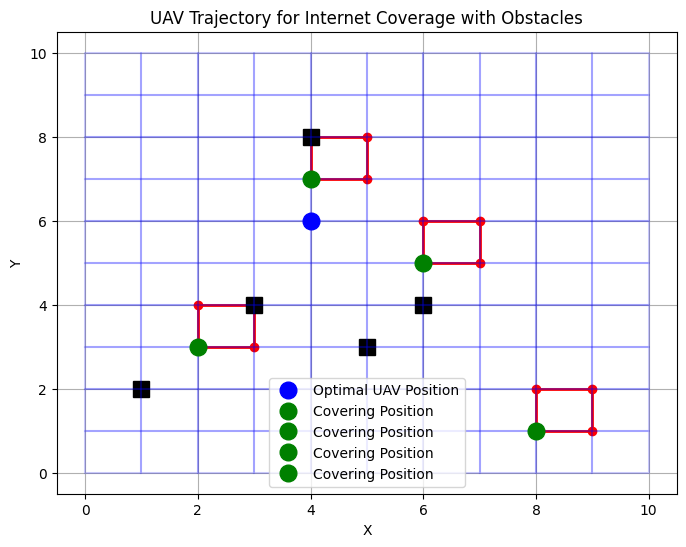

In [ ]:
# Find optimal UAV position
optimal_position = find_optimal_position(q_agent)
print("Optimal UAV Position:", optimal_position)

# Find positions covering remaining rescue zones
uncovered_spots = [spot for spot in no_internet_spots if spot not in [(optimal_position[0], optimal_position[1])]]
covering_positions = find_covering_positions(optimal_position, uncovered_spots, obstacles)
print("Covering Positions:", covering_positions)

# Find optimal paths to covering positions from origin sequentially
origin = (0, 0)
current_position = origin
optimal_paths = []
positions = covering_positions
while covering_positions:
    nearest_position = find_nearest_covering_position(current_position, covering_positions)
    optimal_paths.append(find_optimal_path(current_position, nearest_position, obstacles))
    current_position = nearest_position
    covering_positions.remove(nearest_position)

# Visualization
plt.figure(figsize=(8, 6))
for spot in no_internet_spots:
    plt.plot([spot[0], spot[0]+1, spot[0]+1, spot[0], spot[0]], [spot[1], spot[1], spot[1]+1, spot[1]+1, spot[1]], 'ro-', linewidth=2)
for obstacle in obstacles:
    plt.plot(obstacle[0], obstacle[1], 'ks', markersize=12)  # Plot obstacles as black squares
for x in range(grid_size):
    for y in range(grid_size):
        plt.plot([x, x+1, x+1, x, x], [y, y, y+1, y+1, y], 'b-', alpha=0.2)

# Plot optimal UAV position
plt.plot(optimal_position[0], optimal_position[1], 'bo', markersize=12, label='Optimal UAV Position')

# Plot covering positions
for position in covering_positions:
    plt.plot(position[0], position[1], 'go', markersize=12, label='Covering Position')

plt.title('UAV Trajectory for Internet Coverage with Obstacles')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

In [119]:
# Save optimal UAV positions to CSV file
def save_optimal_positions_to_csv(filename, positions):
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['X', 'Y'])  # Write header
        for position in positions:
            writer.writerow([position[0], position[1]])

# Example usage to save optimal UAV positions
if __name__ == "__main__":
    optimal_position = find_optimal_position(q_agent)
    uncovered_spots = [spot for spot in no_internet_spots if spot not in [(optimal_position[0], optimal_position[1])]]
    covering_positions = find_covering_positions(optimal_position, uncovered_spots, obstacles)

    # Save covering positions to CSV file
    save_optimal_positions_to_csv("zones.csv", covering_positions)


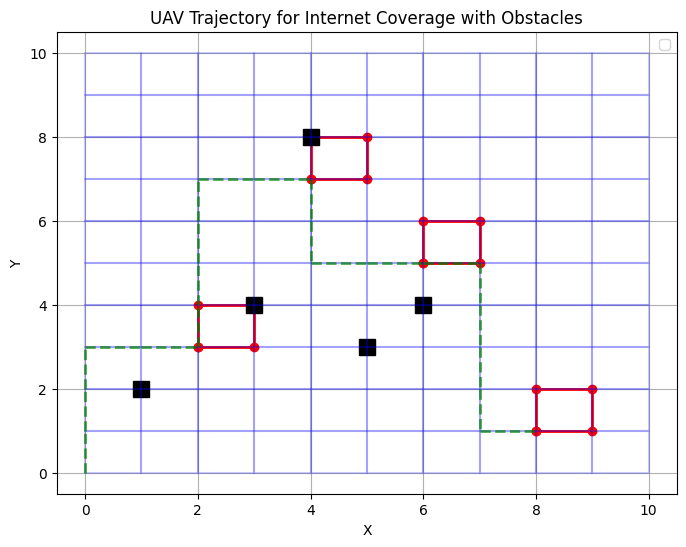

In [ ]:
# Plotting the paths
def plot_paths(optimal_paths):
    for path in optimal_paths:
        for i in range(len(path) - 1):
            plt.plot([path[i][0], path[i+1][0]], [path[i][1], path[i+1][1]], 'g--', linewidth=2, alpha=0.7)

# Visualization
plt.figure(figsize=(8, 6))
for spot in no_internet_spots:
    plt.plot([spot[0], spot[0]+1, spot[0]+1, spot[0], spot[0]], [spot[1], spot[1], spot[1]+1, spot[1]+1, spot[1]], 'ro-', linewidth=2)
for obstacle in obstacles:
    plt.plot(obstacle[0], obstacle[1], 'ks', markersize=12)  # Plot obstacles as black squares
for x in range(grid_size):
    for y in range(grid_size):
        plt.plot([x, x+1, x+1, x, x], [y, y, y+1, y+1, y], 'b-', alpha=0.2)

# Plot paths
plot_paths(optimal_paths)

plt.title('UAV Trajectory for Internet Coverage with Obstacles')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()


# Advanced Trajectory Planning with Dynamic Adaptation (ATPDA)

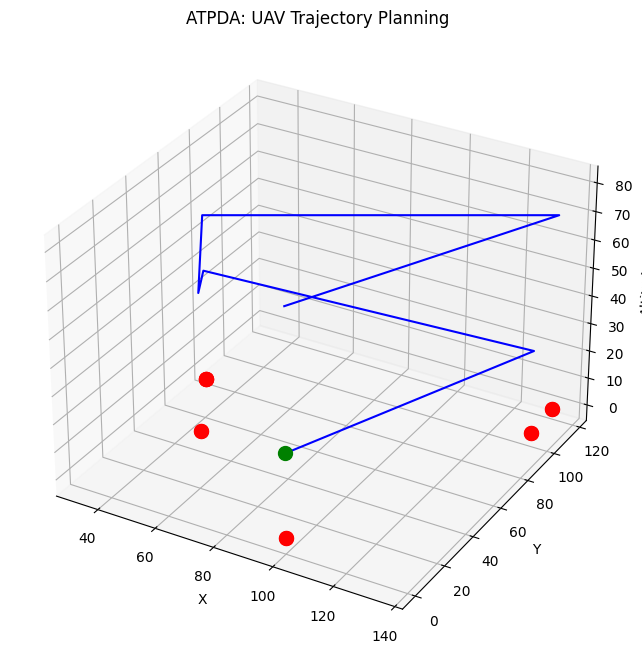

In [ ]:
# Function to visualize the map, zones, and UAV trajectory in 3D
def visualize_map_3d(zones, trajectory):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot predefined zones
    for zone in zones:
        ax.scatter(zone[0], zone[1], 0, color='red', marker='o', s=100, label='Predefined Zone')

    # Plot UAV trajectory
    ax.plot(trajectory[:,0], trajectory[:,1], trajectory[:,2], color='blue', label='UAV Trajectory')

    # Plot takeoff point
    ax.scatter(trajectory[0,0], trajectory[0,1], trajectory[0,2], color='green', marker='o', s=100, label='Takeoff Point')

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Altitude')
    ax.set_title('ATPDA: UAV Trajectory Planning')
    # ax.legend()

    plt.grid(True)
    plt.show()

# Function to generate random predefined zones
def generate_predefined_zones(num_zones, map_size):
    return np.random.rand(num_zones, 2) * map_size

# Placeholder function to determine the optimal coverage position
def determine_optimal_coverage_position(current_position, zones):
    # For demonstration, let's assume the optimal coverage position is the closest predefined zone
    min_distance = np.inf
    optimal_position = None
    for zone in zones:
        distance = np.linalg.norm(np.array(current_position[:2]) - np.array(zone))
        if distance < min_distance:
            min_distance = distance
            optimal_position = zone
    return optimal_position

# Placeholder function to adjust altitude based on optimal coverage position
def adjust_altitude(current_altitude, optimal_coverage_position):

    if np.linalg.norm(np.array(optimal_coverage_position)) > 50:
        return current_altitude + 10
    else:
        return current_altitude

# Placeholder function to fine-tune trajectory to ensure optimal coverage
def fine_tune_trajectory(current_position, optimal_coverage_position):
    # For demonstration, let's assume the fine-tuned trajectory includes intermediate points between current and optimal position
    x1, y1, _ = current_position
    x2, y2 = optimal_coverage_position
    num_points = int(np.linalg.norm(np.array([x2, y2]) - np.array([x1, y1]))) // 10  # 10 units apart
    intermediate_points = np.linspace([x1, y1, current_position[2]], [x2, y2, current_position[2]], num_points, endpoint=False)
    return intermediate_points.tolist()


# Function to implement ATPDA algorithm with Module 2 integration
def ATPDA_3d(grid_size, num_zones, start_position, altitude, grid_resolution):
    # Initialize data
    zones = generate_predefined_zones(num_zones, grid_size)
    trajectory = [list(start_position) + [altitude]]  # Start position with altitude

    obstacles_detected = False

    while True:
        # Determine the next zone to visit
        next_zone = zones[np.random.randint(num_zones)]

        # Compute the shortest path to the next zone
        path_to_next_zone = np.array([trajectory[-1][:2], next_zone])

        # If obstacles are detected, generate an alternative path using dynamic obstacle avoidance techniques
        if obstacles_detected:
            alternative_path = path_to_next_zone
            path_to_next_zone = alternative_path

        # Append the next zone to the trajectory
        trajectory.append(list(next_zone) + [altitude])

        # Check if the UAV is within 50 meters of the next zone
        if np.linalg.norm(trajectory[-1][:2] - next_zone) < 50:
            # Utilize Module 2 policies to determine the optimal coverage position
            optimal_coverage_position = determine_optimal_coverage_position(trajectory[-1], zones)
            trajectory.append(list(optimal_coverage_position) + [altitude])

            # Adjust altitude based on Module 2 policies to optimize coverage
            altitude = adjust_altitude(altitude, optimal_coverage_position)

            # Fine-tune trajectory to ensure optimal coverage while maintaining LoRa signal strength
            fine_tuned_trajectory = fine_tune_trajectory(trajectory[-1], optimal_coverage_position)
            trajectory.extend(fine_tuned_trajectory)

        # Check if the final zone is reached
        if len(trajectory) > 10:
            break

    # Return to the takeoff point following the shortest path
    trajectory.append(list(start_position) + [altitude])

    return np.array(trajectory)

# Define grid size and other parameters
grid_size = 150
num_zones = 5
start_position = np.array([100, 0])
altitude = 30
grid_resolution = 1

trajectory_3d = ATPDA_3d(grid_size, num_zones, start_position, altitude, grid_resolution)

# Visualize the map and trajectory in 3D
visualize_map_3d(trajectory_3d[:,:2], trajectory_3d)


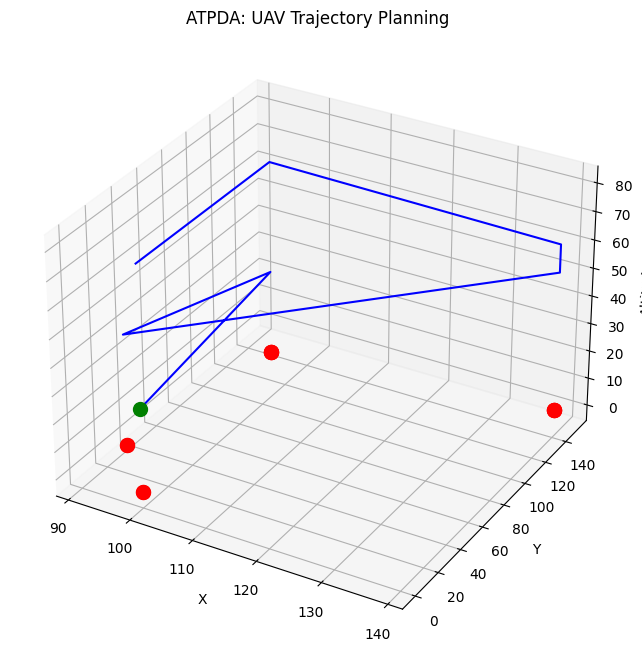

In [ ]:
# Function to visualize the map, zones, and UAV trajectory in 3D
def visualize_map_3d(zones, trajectory):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot predefined zones
    for zone in zones:
        ax.scatter(zone[0], zone[1], 0, color='red', marker='o', s=100, label='Predefined Zone')

    # Plot UAV trajectory
    ax.plot(trajectory[:,0], trajectory[:,1], trajectory[:,2], color='blue', label='UAV Trajectory')

    # Plot takeoff point
    ax.scatter(trajectory[0,0], trajectory[0,1], trajectory[0,2], color='green', marker='o', s=100, label='Takeoff Point')

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Altitude')
    ax.set_title('ATPDA: UAV Trajectory Planning')
    # ax.legend()

    plt.grid(True)
    plt.show()

# Function to generate random predefined zones
def generate_predefined_zones(num_zones, map_size):
    return np.random.rand(num_zones, 2) * map_size

# Placeholder function to determine the optimal coverage position
def determine_optimal_coverage_position(current_position, zones):
    # For demonstration, let's assume the optimal coverage position is the closest predefined zone
    min_distance = np.inf
    optimal_position = None
    for zone in zones:
        distance = np.linalg.norm(np.array(current_position[:2]) - np.array(zone))
        if distance < min_distance:
            min_distance = distance
            optimal_position = zone
    return optimal_position

# Placeholder function to adjust altitude based on optimal coverage position
def adjust_altitude(current_altitude, optimal_coverage_position):

    if np.linalg.norm(np.array(optimal_coverage_position)) > 50:
        return current_altitude + 10
    else:
        return current_altitude

# Placeholder function to fine-tune trajectory to ensure optimal coverage
def fine_tune_trajectory(current_position, optimal_coverage_position):
    # For demonstration, let's assume the fine-tuned trajectory includes intermediate points between current and optimal position
    x1, y1, _ = current_position
    x2, y2 = optimal_coverage_position
    num_points = int(np.linalg.norm(np.array([x2, y2]) - np.array([x1, y1]))) // 10  # 10 units apart
    intermediate_points = np.linspace([x1, y1, current_position[2]], [x2, y2, current_position[2]], num_points, endpoint=False)
    return intermediate_points.tolist()


# Function to implement ATPDA algorithm with Module 2 integration
def ATPDA_3d(grid_size, num_zones, start_position, altitude, grid_resolution):
    # Initialize data
    zones = generate_predefined_zones(num_zones, grid_size)
    trajectory = [list(start_position) + [altitude]]  # Start position with altitude

    obstacles_detected = False

    while True:
        # Determine the next zone to visit
        next_zone = zones[np.random.randint(num_zones)]

        # Compute the shortest path to the next zone
        path_to_next_zone = np.array([trajectory[-1][:2], next_zone])

        # If obstacles are detected, generate an alternative path using dynamic obstacle avoidance techniques
        if obstacles_detected:
            alternative_path = path_to_next_zone
            path_to_next_zone = alternative_path

        # Append the next zone to the trajectory
        trajectory.append(list(next_zone) + [altitude])

        # Check if the UAV is within 50 meters of the next zone
        if np.linalg.norm(trajectory[-1][:2] - next_zone) < 50:
            # Utilize Module 2 policies to determine the optimal coverage position
            optimal_coverage_position = determine_optimal_coverage_position(trajectory[-1], zones)
            trajectory.append(list(optimal_coverage_position) + [altitude])

            # Adjust altitude based on Module 2 policies to optimize coverage
            altitude = adjust_altitude(altitude, optimal_coverage_position)

            # Fine-tune trajectory to ensure optimal coverage while maintaining LoRa signal strength
            fine_tuned_trajectory = fine_tune_trajectory(trajectory[-1], optimal_coverage_position)
            trajectory.extend(fine_tuned_trajectory)

        # Check if the final zone is reached
        if len(trajectory) > 10:
            break

    # Return to the takeoff point following the shortest path
    trajectory.append(list(start_position) + [altitude])

    return np.array(trajectory)

# Define grid size and other parameters
grid_size = 150
num_zones = 5
start_position = np.array([100, 0])
altitude = 30
grid_resolution = 1

trajectory_3d = ATPDA_3d(grid_size, num_zones, start_position, altitude, grid_resolution)

# Visualize the map and trajectory in 3D
visualize_map_3d(trajectory_3d[:,:2], trajectory_3d)
